##Mount and Import

In [ ]:
!pip install google

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from sklearn.model_selection import train_test_split
pd.options.display.max_colwidth = 150
import nlpaug.augmenter.word as naw

In [3]:
!pip install tweet-preprocessor
!pip install transformers
!pip install sentencepiece
!pip install nlpaug
!pip install fairseq
!pip install fastBPE

In [ ]:
data_en = pd.read_csv("/content/drive/MyDrive/Data Mining/Project/Data/Final Dataset.csv",encoding='Latin1',error_bad_lines=False) 
# Preview the first 5 lines of the loaded data 
data_en.head()

,Tweet,Suicide
0,i hate myself so much i want to KILL myself how are yâall?!?! ð¥´ð¥´,_Suicidal_
1,"RT @DrugForumsBest: I woke up with a bag over my head after I intentionally overdosed on a conbo of 250 mg diclazepam, half a handle of bouâ¦",_Suicidal_
2,i wanna fucking kill myself,_Suicidal_
3,"why do i destroy all my opportunities? am i going to kill myself on accident? if i only get worse, does that mean aâ¦ https://t.co/Ur1sapAyLo",_Suicidal_
4,u - understand what the fuck im doing wrong with my life,_Suicidal_


In [8]:
data_en.tail(10)
#print(data[data['Suicide'] == "_Suicidal_"].size , data[data['Suicide'] == "_NotSuicidal_"].size)

,Unnamed: 0,text,label
48098,48098,thank you precious woman may you receive that and exceedingly more than you could ever hope for or imagine,0
48099,48099,wow powerful prayer,0
48100,48100,mother depress like first good mother father therapist everi stop caus everyth go back work day got nervou breakdown made thing even wors got medi...,0
48101,48101,can have yours cloud have come in fear may be too late to enjoy the weather,0
48102,48102,depress life unfortun cope emot eat food addict depress musical theme enjoy life think beauti also regretful mortal brush tooth go somewher hardli...,1
48103,48103,anyon feel like wast lot time around make stop know need help know job motiv person knew,1
48104,48104,rt mod silence suicide and dubbing of rohit a anti national by bop show anti stand of bjp,1
48105,48105,well first post know anyon read thread year old male live hit may current year interest constantli spiral struggl find lie lot peopl especi around...,1
48106,48106,thanks everyone came king performance comedy,0
48107,48107,depress togeth long minor one rather major one one countri know much experi first hand last week bit fallen anoth one isol speak anyon sister repl...,0


##Data Preprocessing

In [ ]:
print(data_en[data_en['Suicide'] == "_Suicidal_"].size/2 , data_en[data_en['Suicide'] == "_NotSuicidal_"].size/2)

4568.0 25268.0


In [ ]:
import preprocessor as p
def preprocess_tweet(row):
    text = p.clean(row)
    return text

data_en['Tweet'] = data_en['Tweet'].apply(lambda x: str(x).replace("[","").replace("'","").replace(",","").replace("]","") if str(x).startswith('[') else str(x))
data_en['Tweet'] = data_en['Tweet'].apply(lambda x: preprocess_tweet(x))
data_en['Suicide'] = data_en['Suicide'].apply(lambda x: 1 if x == "_Suicidal_" else 0)

data_en.tail(10)

,Tweet,Suicide
29826,everyon know best friend mental hospit eat disord told write often yesterday bad best miss much feel someon advic improv,1
29827,probabl realli common hard troubl feel awkward place feel like plan say els come mess common,0
29828,ever sinc danc grade danc competit group lot fun back forward next year select basic pretti rich enough tri year found consciou shi awkward unabl ...,0
29829,hey got home hospit suicid attempt mayb give background year old femal depress anxieti eat disord two first say anyway intens may form year suicid...,1
29830,talk depress feel one school know averag high school teenag drama howev realli get late suicid past histori self harm school real know tri make ma...,0
29831,real angri late cours know lot time straight apathi activ everyth recent wonder usual allevi help tone way affect everyon self gotten time snap bi...,0
29832,first post honestli know els post need talk ever sinc everyon stood birthday back stop go stop hang gym buddi state get realli comfort game bigger...,0
29833,care much care wait even wors think real make futur realiz nobodi realiz nobodi hug kiss realiz chang mayb worst part realiz fault,1
29834,cannot stand anyth within life find unhappi everyth even split second happi sad shadow creep behind happi shortli would like noth wake like accomp...,0
29835,enough pain depress run way save everi distract help get back two take put life hold ahead take care even though bare first two day semest colleg ...,1


**Train Validation Test Split**

In [9]:
X = data_en.Tweet.values
y = data_en.Suicide.values

X_train_en, X_test_en, y_train_en, y_test_en \
    = train_test_split(X, y, test_size=0.2, random_state=1)

X_train_en, X_val_en, y_train_en, y_val_en \
    = train_test_split(X_train_en, y_train_en, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print(len(X_train_en),len(X_val_en),len(X_test_en))
#print(Y_train == 1].size/2 , y_val == 1.size/2, y_test == 1)
print(len(X_val_en[np.where(y_val_en==1)]),len(X_val_en[np.where(y_val_en==0)] ))
print(len(X_test_en[np.where(y_test_en==1)]),len(X_test_en[np.where(y_test_en==0)] ))

AttributeError: ignored

In [13]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [14]:
def text_preprocessing(text):
  if str(text).startswith('['): 
    text = str(text).replace("[","").replace("'","").replace(",","").replace("]","")
  return text

In [ ]:
data_en.to_csv("/content/drive/MyDrive/Data Mining/Project/Data/Clean Dataset.csv", index=False)

In [15]:
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    #print(probs.size,y_true.size,y_pred.size)
    accuracy = accuracy_score(y_true, y_pred)
    F1_score = f1_score(y_true,y_pred)
    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred);
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(f'F1 score: {F1_score*100:.2f}%')
    print(f'Precision: {precision*100:.2f}%')
    print(f'Recall: {recall*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Data Augmentation

Split Suicidal and non-Suicidal tweets. Only augment the suicidal tweets in train data. 

In [5]:
data_en = pd.read_csv("/content/drive/MyDrive/Data Mining/Project/Data/Augmented_Datasets.csv",encoding='Latin1',error_bad_lines=False) 
# Preview the first 5 lines of the loaded data 
data_en.head()

,Unnamed: 0,text,label
0,0,would never make bad,0
1,1,woke around cri woke could immedi ask come comfort spent cri think go kill tonight go fail school tomorrow without homework multipl,1
2,2,thought sprightliness turn around self harm hopeless gotten better found stop cut even stop smoke face forward noth accept colleg way afford even ...,1
3,3,Decid doctor cut abl sleep end take regular night sinc appoint anyon advic well stay sleep step,1
4,4,drinking gingerbread brown ale,0


In [8]:
data_en = data_en.dropna()
data_en.isnull().sum()


Unnamed: 0    0
text          0
label         0
dtype: int64

In [9]:
X = data_en.text.values
y = data_en.label.values

X_train_en, X_test_en, y_train_en, y_test_en \
    = train_test_split(X, y, test_size=0.2, random_state=1)

X_train_en, X_val_en, y_train_en, y_val_en \
    = train_test_split(X_train_en, y_train_en, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print(len(X_train_en),len(X_val_en),len(X_test_en))
#print(Y_train == 1].size/2 , y_val == 1.size/2, y_test == 1)
print(len(X_val_en[np.where(y_val_en==1)]),len(X_val_en[np.where(y_val_en==0)] ))
print(len(X_test_en[np.where(y_test_en==1)]),len(X_test_en[np.where(y_test_en==0)] ))

28853 9618 9618
4497 5121
4568 5050


In [ ]:
pos = X_train_en[np.where(y_train_en==1)[0]]
neg = X_train_en[np.where(y_train_en==0)[0]]
print(len(pos), len(neg), len(neg)/len(pos))
pos_labels = y_train_en[np.where(y_train_en==1)[0]]
neg_labels = y_train_en[np.where(y_train_en==0)[0]]

2775 15126 5.450810810810811


These are
1.   **Synonym Replacement:** Randomly choose n words from the sentence that are not stop words. Replace each of these words with one of its synonyms chosen at random.
2.   **Random Insertion:** Find a random synonym of a random word in the sentence that is not a stop word. Insert that synonym into a random position in the sentence. Do this n times
3.   **Random Swap:** Randomly choose two words in the sentence and swap their positions. Do this n times
4.   **Random Deletion:** Randomly remove each word in the sentence with probability p

In [ ]:
import nltk
nltk.download('wordnet')
import random
from random import shuffle
random.seed(1)

stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
            'ours', 'ourselves', 'you', 'your', 'yours', 
            'yourself', 'yourselves', 'he', 'him', 'his', 
            'himself', 'she', 'her', 'hers', 'herself', 
            'it', 'its', 'itself', 'they', 'them', 'their', 
            'theirs', 'themselves', 'what', 'which', 'who', 
            'whom', 'this', 'that', 'these', 'those', 'am', 
            'is', 'are', 'was', 'were', 'be', 'been', 'being', 
            'have', 'has', 'had', 'having', 'do', 'does', 'did',
            'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
            'because', 'as', 'until', 'while', 'of', 'at', 
            'by', 'for', 'with', 'about', 'against', 'between',
            'into', 'through', 'during', 'before', 'after', 
            'above', 'below', 'to', 'from', 'up', 'down', 'in',
            'out', 'on', 'off', 'over', 'under', 'again', 
            'further', 'then', 'once', 'here', 'there', 'when', 
            'where', 'why', 'how', 'all', 'any', 'both', 'each', 
            'few', 'more', 'most', 'other', 'some', 'such', 'no', 
            'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
            'very', 's', 't', 'can', 'will', 'just', 'don', 
            'should', 'now', '']

import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    #if clean_line[0] == ' ':
    #    clean_line = clean_line[1:]
    return clean_line
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            #print("replaced", random_word, "with", synonym)
            num_replaced += 1
        if num_replaced >= n: #only replace up to n words
            break

    #this is stupid but we need it, trust me
    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return new_words

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def random_deletion(words, p):

    #obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    #randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    #if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    return new_words

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):

    sentence = get_only_chars(sentence)
    words = sentence.split(' ')
    words = [word for word in words if word is not '']
    num_words = len(words)

    if num_words == 0:
        return [""] * num_aug
    augmented_sentences = []
    num_new_per_technique = int(num_aug/4)+1
    n_sr = max(1, int(alpha_sr*num_words))
    n_ri = max(1, int(alpha_ri*num_words))
    n_rs = max(1, int(alpha_rs*num_words))

    #sr
    for _ in range(num_new_per_technique):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))

    #ri
    for _ in range(num_new_per_technique):
        a_words = random_insertion(words, n_ri)
        augmented_sentences.append(' '.join(a_words))

    #rs
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(' '.join(a_words))

#rd
    for _ in range(num_new_per_technique):
        a_words = random_deletion(words, p_rd)
        augmented_sentences.append(' '.join(a_words))

    augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
    shuffle(augmented_sentences)

#trim so that we have the desired number of augmented sentences
    if num_aug >= 1:
        augmented_sentences = np.random.choice(augmented_sentences, num_aug, replace=False)
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]


    return augmented_sentences

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
print(pos[0], len(eda(pos[0],num_aug=4) ))
pos_aug = []
for tweet in pos:
  for l in eda_using_nlpaug(tweet,num_aug=4): 
  #for l in contextual_word_embeddings_augmenter(tweet,num_aug=4):
    pos_aug.append(l)
print(len(pos_aug))
print(pos_aug[0])

past day mood happi certainli content life think energi mostli convinc stop colleg great tell care slip back depress say next trust care day calm 4
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
5550
past day mood happi certainli content life sentence think energi mostli convinc stop colleg heavy tell care slip backward depress say next trust care day calm


In [ ]:
pos_aug_labels = len(pos_aug) * [1]
print(len(pos_aug_labels))
X_train_en = np.concatenate((pos, pos_aug, neg ))
y_train_en = np.concatenate((pos_labels, pos_aug_labels, neg_labels))
print(len(X_train_en), len(y_train_en))
print(type(pos),type(neg), type(X_train_en))

5550
23451 23451
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [45]:
def eda_using_nlpaug(sentence, num_aug=5):
  augmented_sentences = []
  ### Substitute word by WordNet's synonym
  aug = naw.SynonymAug(aug_src='wordnet')
  augmented_sentences.append(aug.augment(sentence))
  ### Antonym Augmenter
  #aug = naw.AntonymAug()
  #augmented_sentences.append(aug.augment(sentence))
  ### Random Word Augmenter
  #aug = naw.RandomWordAug(action="swap")
  #augmented_sentences.append(aug.augment(sentence))
  ### Delete word randomly
  aug = naw.RandomWordAug()
  augmented_sentences.append(aug.augment(sentence))
  return augmented_sentences

In [ ]:
print(eda_using_nlpaug(text))

['The quick brown fox stick out terminated the lazy dog', 'The quick brown fox jumped over the lazy dog', 'The quick brown jumped fox over the dog lazy', 'The quick brown fox jumped the lazy']


In [ ]:
import csv
  
# data to be written row-wise in csv fil
#data = [['Geeks'], [4], ['geeks !']]
  
# opening the csv file in 'w+' mode
file = open('/content/drive/MyDrive/Data Mining/Project/Data/final_pos_contextual.csv', 'w+', newline ='')
  
# writing the data into the file
with file:    
    write = csv.writer(file)
    write.writerows(pos_aug)

BackTranslation

In [ ]:

text = 'The quick brown fox jumped over the lazy dog'

In [ ]:


back_translation_aug = naw.BackTranslationAug(
    from_model_name='transformer.wmt19.en-de', 
    to_model_name='transformer.wmt19.de-en'
)
back_translation_aug.augment(text)

Using cache found in /root/.cache/torch/hub/pytorch_fairseq_master
Using cache found in /root/.cache/torch/hub/pytorch_fairseq_master
100%|██████████| 11958904958/11958904958 [04:30<00:00, 44169633.59B/s]


TypeError: ignored

**Contextual Word Embeddings Augmenter**




In [ ]:
def contextual_word_embeddings_augmenter(sentence, num_aug=5):
  augmented_sentences = []
  words = sentence.split(" ")
  print(len(words))
  if(len(words) > 511):
    sentence = " ".join(words[0:511])
  ### Substitute word by WordNet's synonym
  aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
  augmented_sentences.append(aug.augment(sentence))
  ### Antonym Augmenter
  aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")
  augmented_sentences.append(aug.augment(sentence))
  ### Random Word Augmenter
  aug = naw.ContextualWordEmbsAug(
    model_path='distilbert-base-uncased', action="substitute")
  augmented_sentences.append(aug.augment(sentence))
  ### Delete word randomly
  aug = naw.ContextualWordEmbsAug(
    model_path='roberta-base', action="substitute")
  augmented_sentences.append(aug.augment(sentence))
  return augmented_sentences

print(eda_using_nlpaug(text))

['The prompt brown fox jumped over the faineant dog', 'The quick brown jumped over the lazy']


In [ ]:
####Insert word by contextual word embeddings (BERT, DistilBERT, RoBERTA or XLNet)

aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert")
augmented_text = aug.augment(pos[0])
print("Original:")
print(pos[0])
print("Augmented Text:")
print(augmented_text)

Original:
past day mood happi certainli content life think energi mostli convinc stop colleg great tell care slip back depress say next trust care day calm
Augmented Text:
more past day mood happi certainli content life i think energi mostli e convinc stop that colleg great love tell care can slip cure back depress say be next round trust care return day calm


In [ ]:
#### Substitute word by contextual word embeddings (BERT, DistilBERT, RoBERTA or XLNet)

aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")
augmented_text = aug.augment(pos[0])
print("Original:")
print(pos[0])
print("Augmented Text:")
print(augmented_text)

Original:
past day mood happi certainli content life think energi mostli convinc stop colleg great tell care slip back depress say next trust care day calm
Augmented Text:
remember sad mood happi this is dead think remember to convinc stop colleg and tell care slip back think say next trust care stop calm


# Training with BERT 
---


In [10]:
from transformers import BertTokenizer

# Instantiate the Bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [12]:
# How many words (tokens) does Bert have in it's vocab?

len(tokenizer.vocab)

30522

**BERT Tokenizer**

In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([X_train_en, X_val_en, X_test_en])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1306 > 512). Running this sequence through the model will result in indexing errors


Max length:  2040


40936


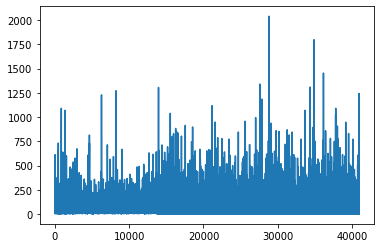

In [ ]:
length = []
for sent in encoded_tweets:
  length.append(len(sent))
print(len(length))
plt.plot(np.array(length))
plt.show()

In [16]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train_en)
val_inputs, val_masks = preprocessing_for_bert(X_val_en)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  would never make bad
Token IDs:  [101, 2052, 2196, 2191, 2919, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


**Create PyTorch DataLoader**

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train_en)
val_labels = torch.tensor(y_val_en)
print(len(y_train_en), y_train_en[:100])

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
print(train_inputs.shape,train_masks.shape,train_labels.shape)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
print(val_inputs.shape,val_masks.shape,val_labels.shape)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

28853 [0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0
 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0]
torch.Size([28853, 64]) torch.Size([28853, 64]) torch.Size([28853])
torch.Size([9618, 64]) torch.Size([9618, 64]) torch.Size([9618])


**Train Our Model**


> Create BertClassifier



In [18]:
%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


**Optimizer & Learning Rate Scheduler**

In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

**Training Loop**

In [20]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [21]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.556554   |     -      |     -     |   7.05   
   1    |   40    |   0.444156   |     -      |     -     |   6.49   
   1    |   60    |   0.451624   |     -      |     -     |   6.55   
   1    |   80    |   0.420307   |     -      |     -     |   6.58   
   1    |   100   |   0.412840   |     -      |     -     |   6.62   
   1    |   120   |   0.393636   |     -      |     -     |   6.69   
   1    |   140   |   0.415951   |     -      |     -     |   6.72   
   1    |   160   |   0.367157   |     -      |     -     |   6.77   
   1    |   180   |   0.418021   |     -      |     -     |   6.82   
   1    |   200   |   0.392579   |     -      |     -     |   6.85   
   1    |   220   |   0.383264   |     -      |     -     |   6.88   
   1    |   240   |   0.375071   |     -      |     -     |   6.91   


**Evaluation on Validation**

In [22]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.9854
Accuracy: 95.50%
F1 score: 95.27%
Precision: 93.59%
Recall: 97.02%


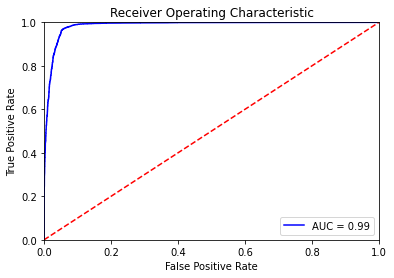

In [23]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val_en)

**Train Our Model on the Entire Training Data**

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, full_train_dataloader, epochs=4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.560262   |     -      |     -     |   8.08   
   1    |   40    |   0.402141   |     -      |     -     |   7.78   
   1    |   60    |   0.430148   |     -      |     -     |   7.72   
   1    |   80    |   0.430717   |     -      |     -     |   7.66   
   1    |   100   |   0.394778   |     -      |     -     |   7.53   
   1    |   120   |   0.400313   |     -      |     -     |   7.43   
   1    |   140   |   0.386000   |     -      |     -     |   7.36   
   1    |   160   |   0.314077   |     -      |     -     |   7.31   
   1    |   180   |   0.363212   |     -      |     -     |   7.29   
   1    |   200   |   0.401627   |     -      |     -     |   7.31   
   1    |   220   |   0.376297   |     -      |     -     |   7.33   
   1    |   240   |   0.371325   |     -      |     -     |   7.37   


**Predictions on Test Set**
> Data Preparation



In [ ]:
#X_test.sample(5)

In [25]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test_en)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Predictions**

Number of tweets predicted non-negative:  4662
AUC: 0.9836
Accuracy: 95.34%
F1 score: 95.15%
Precision: 94.19%
Recall: 96.13%


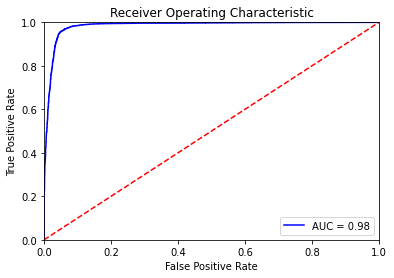

In [26]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())
evaluate_roc(probs, y_test_en)

In [ ]:
output = X_test_en[preds==1]
pd.options.display.max_colwidth = 200
pd.DataFrame(output).sample(20)

,0
199,depress stupid self everyth love friend left lost talk two male feel like worthless cheat talk desper want emot support noth lie cheat
929,Rt fatdill_ : i\u2019ve lost family members and my brother to suicide anxiety and depression is real but don\u2019t ever think us cause you have i\u2026
693,i\u2019ve deleted every suicide note i started in my notes on my phone ... y\u2019all don\u2019t understand how big that is for me
798,write keep panic much stori coupl ago met girl talk last year broke send money sinc pretti much like way even want help broke kept got marri offic relationship badli terribl mood extrem tell eat e...
874,It\u2019s not suicide if these drugs kill me
578,"Im gonna fucking die, im tired of investing everything into a person and then have them throw it out. I am not made"
824,closer one half graduat unless someth unless feel better know probabl happi long time might end got noth look forward bare anyth hold right tomorrow day realli yeah tire wait fail
924,littl better sinc first post gotten help still made new learn feel better right happi view world know long last found hope thank wonder support also start there
490,"Rt psych_hype : suicidal behavior has nearly doubled among children -18 , with suicidal thoughts and attempts leading to more than mill\u2026"
174,know make stop habit alway first place mind go think happi posit mood incred feel


# Training with ROBERTA 
---


In [27]:
from transformers import RobertaTokenizer

# Instantiate the Bert tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

In [ ]:
# How many words (tokens) does Bert have in it's vocab?

len(tokenizer.vocab)

30522

**BERT Tokenizer**

In [29]:
from transformers import RobertaTokenizer

# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([X_train_en, X_val_en, X_test_en])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1238 > 512). Running this sequence through the model will result in indexing errors


Max length:  1828


40936


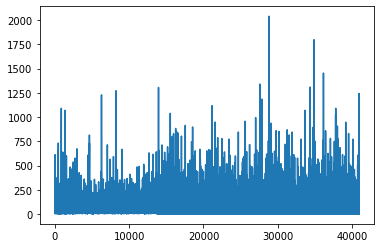

In [ ]:
length = []
for sent in encoded_tweets:
  length.append(len(sent))
print(len(length))
plt.plot(np.array(length))
plt.show()

In [30]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train_en)
val_inputs, val_masks = preprocessing_for_bert(X_val_en)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  would never make bad
Token IDs:  [0, 14656, 393, 146, 1099, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokenizing data...


**Create PyTorch DataLoader**

In [31]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train_en)
val_labels = torch.tensor(y_val_en)
print(len(y_train_en), y_train_en[:100])

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
print(train_inputs.shape,train_masks.shape,train_labels.shape)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
print(val_inputs.shape,val_masks.shape,val_labels.shape)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

28853 [0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0
 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0]
torch.Size([28853, 64]) torch.Size([28853, 64]) torch.Size([28853])
torch.Size([9618, 64]) torch.Size([9618, 64]) torch.Size([9618])


**Train Our Model**


> Create BertClassifier



In [32]:
%time
import torch
import torch.nn as nn
from transformers import RobertaModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = RobertaModel.from_pretrained('roberta-base')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


**Optimizer & Learning Rate Scheduler**

In [34]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

**Training Loop**

In [35]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [36]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.562250   |     -      |     -     |   7.62   
   1    |   40    |   0.498801   |     -      |     -     |   7.32   
   1    |   60    |   0.492888   |     -      |     -     |   7.32   
   1    |   80    |   0.471443   |     -      |     -     |   7.25   
   1    |   100   |   0.448360   |     -      |     -     |   7.15   
   1    |   120   |   0.514854   |     -      |     -     |   7.11   
   1    |   140   |   0.407168   |     -      |     -     |   7.07   
   1    |   160   |   0.417014   |     -      |     -     |   7.06   
   1    |   180   |   0.396274   |     -      |     -     |   7.05   
   1    |   200   |   0.397323   |     -      |     -     |   7.07   
   1    |   220   |   0.433981   |     -      |     -     |   7.07   
   1    |   240   |   0.408568   |     -      |     -     |   7.07   


**Evaluation on Validation**

In [37]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.9807
Accuracy: 94.51%
F1 score: 94.24%
Precision: 92.52%
Recall: 96.02%


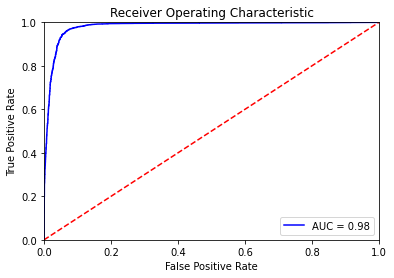

In [38]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val_en)

**Train Our Model on the Entire Training Data**

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, full_train_dataloader, epochs=4)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.406296   |     -      |     -     |   7.83   
   1    |   40    |   0.351000   |     -      |     -     |   7.51   
   1    |   60    |   0.303648   |     -      |     -     |   7.49   
   1    |   80    |   0.360015   |     -      |     -     |   7.51   
   1    |   100   |   0.338939   |     -      |     -     |   7.53   
   1    |   120   |   0.344593   |     -      |     -     |   7.52   
   1    |   140   |   0.335142   |     -      |     -     |   7.51   
   1    |   160   |   0.273107   |     -      |     -     |   7.46   
   1    |   180   |   0.273071   |     -      |     -     |   7.49   
   1    |   200   |   0.309945   |     -      |     -     |   7.48   
   1    |   220   |   0.253586   |     -      |     -     |   7.46   
   1    |   240   |   0.350430   |     -      |     -     |   7.49   


**Predictions on Test Set**
> Data Preparation



In [ ]:
#X_test.sample(5)

In [39]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test_en)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Predictions**

Number of tweets predicted non-negative:  4680
AUC: 0.9797
Accuracy: 94.32%
F1 score: 94.10%
Precision: 92.97%
Recall: 95.25%


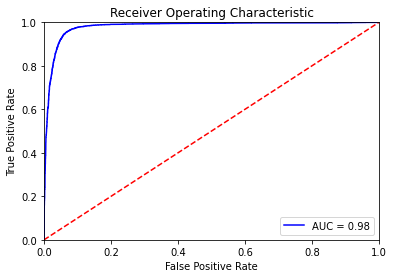

In [40]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())
evaluate_roc(probs, y_test_en)

In [41]:
output = X_test_en[preds==1]
pd.options.display.max_colwidth = 200
pd.DataFrame(output).sample(20)

,0
3779,kenneth starr admits u00a0omitted he in fbi that report hillary clinton vince triggered suicide foster co http hgiyjbm3 u2026
33,Like left treat help miss feel alon noth want life someon
2063,everi singl problem fear loath self fault one ever done anyth bad noth gone badli wrong control never wrong thing wrong time well say problem everi friendship lost everi friendship everi never stu...
4258,rt im2slothy suicide hot line number ud83d udcde nunited kingdom
2627,prime time afternoon game prime time night night night see trend packer fox game week prime time anyways good evening
1936,rt chulipies if you make fun of someone u2019s suicide attempt specially someone younger than you you u2019re truly trash human cost and an u2026
2213,depress video watch music listen tri back get whatev gotten point liter last around think hate much get back cope think track could use
2304,titl want leave support anyon talk without feel guilt shame self help group interest
3311,background clinic depress add know fix overwhelm job kill get famili suck start bottom go most one work half cant take constantli around work hard noth taken told that suck sick work take sick mak...
1244,kenneth starr reject he u00a0omitted in fbi report that hillary clinton triggered vince foster suicide http co hgiyjbm3 u2026


# Spanish Dataset


In [42]:
data_sp = pd.read_csv("/content/drive/MyDrive/Data Mining/Project/Data/Spanish/suicidio_notacion.csv",encoding='Latin1',error_bad_lines=False) 
# Preview the first 5 lines of the loaded data 
data_sp.head()

,tweet_clean,suicidio
0,hay veces que vas a estar sÃºper triste cansado de todo derrotado y sin ganas de hacer nada quieres llorar estar solo,0
1,que cansado de estar solo precisaria esa persona que se que puedo contar con ella tanto para los malos como buenos m,0
2,estoy harto de todo y todos solo quiero estar solo no quiero saber ni del baile ni del carnaval ni de la escuel,0
3,tener ansiedad y depresiÃ³n es estar asustado y cansado al mismo tiempo es el miedo al fracaso pero no hay necesidad de ser p,0
4,este pibe me puso q estaba cansado de estar solo y yo le respondÃ­ que la pasarÃ­a bien en soledad si tuviera libros,0


In [ ]:
print(data_sp[data_sp['suicidio'] == 0].size/2 , data_sp[data_sp['suicidio'] == 1].size/2)

1571.0 497.0


In [43]:
X = data_sp.tweet_clean.values
y = data_sp.suicidio.values

X_train_sp, X_test_sp, y_train_sp, y_test_sp \
    = train_test_split(X, y, test_size=0.2, random_state=1)

X_train_sp, X_val_sp, y_train_sp, y_val_sp \
    = train_test_split(X_train_sp, y_train_sp, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print(len(X_train_sp),len(X_val_sp),len(X_test_sp))
#print(Y_train == 1].size/2 , y_val == 1.size/2, y_test == 1)
print(len(X_val_sp[np.where(y_val_sp==1)]),len(X_val_sp[np.where(y_val_sp==0)] ))
print(len(X_test_sp[np.where(y_test_sp==1)]),len(X_test_sp[np.where(y_test_sp==0)] ))

1240 414 414
103 311
92 322


Data Augmentation

In [46]:
pos = X_train_sp[np.where(y_train_sp==1)[0]]
neg = X_train_sp[np.where(y_train_sp==0)[0]]
print(len(pos), len(neg), len(neg)/len(pos))
pos_labels = y_train_sp[np.where(y_train_sp==1)[0]]
neg_labels = y_train_sp[np.where(y_train_sp==0)[0]]

302 938 3.1059602649006623


In [47]:
pos_aug = []
for tweet in pos:
  #for l in eda(tweet,num_aug=4): 
  for l in eda_using_nlpaug(tweet,num_aug=2):
    pos_aug.append(l)
print(len(pos_aug))
print(pos_aug[0])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
604
rubidium no quiero estar mas aqui


In [48]:
pos_aug_labels = len(pos_aug) * [1]
print(len(pos_aug_labels))
X_train_sp = np.concatenate((pos, pos_aug, neg ))
y_train_sp = np.concatenate((pos_labels, pos_aug_labels, neg_labels))
print(len(X_train_sp), len(y_train_sp))
print(type(pos),type(neg), type(X_train_sp))

604
1844 1844
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Training with XLM-ROBERTA

---



XLM-ROBERTA Tokenizer

In [49]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

MODEL_TYPE = 'xlm-roberta-base'

# Load the XLM-ROBERTA tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_xlm_roberta(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [51]:
# Specify `MAX_LEN`
MAX_LEN = 64
X_train = np.concatenate([X_train_en, X_train_sp])
X_val = np.concatenate([X_val_en, X_val_sp])

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_xlm_roberta([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_xlm_roberta(X_train)
val_inputs, val_masks = preprocessing_for_xlm_roberta(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  hay veces que vas a estar sÃºper triste cansado de todo derrotado y sin ganas de hacer nada quieres llorar estar solo
Token IDs:  [0, 2054, 16374, 41, 4191, 10, 5747, 91, 7492, 42227, 34757, 99616, 246, 8, 1973, 88943, 246, 113, 880, 79304, 8, 6303, 5799, 66004, 115219, 3701, 5747, 2639, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokenizing data...


**Create Pytorch Dataloader**

In [52]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

y_train = np.concatenate([y_train_en, y_train_sp])
y_val = np.concatenate([y_val_en, y_val_sp])

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
print(len(y_train), y_train[:100])

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
print(train_inputs.shape,train_masks.shape,train_labels.shape)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
print(val_inputs.shape,val_masks.shape,val_labels.shape)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

30697 [0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0
 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0]
torch.Size([30697, 64]) torch.Size([30697, 64]) torch.Size([30697])
torch.Size([10032, 64]) torch.Size([10032, 64]) torch.Size([10032])


**Train our model**

In [53]:
%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class XLMRobertaClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(XLMRobertaClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.xlm_roberta = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        #if freeze_bert:
         #   for param in self.bert.parameters():
          #      param.requires_grad = False
        
    def forward(self, input_ids, attention_mask, c_labels = ""):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.xlm_roberta(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels = c_labels)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        #last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        #logits = self.classifier(last_hidden_state_cls)

        return outputs

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [54]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    xlm_roberta_classifier = XLMRobertaClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    xlm_roberta_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(xlm_roberta_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return xlm_roberta_classifier, optimizer, scheduler

In [55]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask,b_labels)

            # Compute loss and accumulate the loss values
            #loss = loss_fn(logits, b_labels)
            loss = logits[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask, b_labels)

        # Compute loss
        #loss = loss_fn(logits, b_labels)
        loss = logits[0]
        val_loss.append(loss.item())

        # Get the preds
        preds = logits[1]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()

        # Get the predictions
        preds = torch.argmax(preds, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [56]:
set_seed(42)    # Set seed for reproducibility
xlm_roberta_classifier, optimizer, scheduler = initialize_model(epochs=2)
import torch
torch.cuda.empty_cache()
import gc
#del variables
gc.collect()
train(xlm_roberta_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.638167   |     -      |     -     |   8.72   
   1    |   40    |   0.670875   |     -      |     -     |   8.33   
   1    |   60    |   0.548310   |     -      |     -     |   8.35   
   1    |   80    |   0.543410   |     -      |     -     |   8.37   
   1    |   100   |   0.537873   |     -      |     -     |   8.39   
   1    |   120   |   0.523576   |     -      |     -     |   8.43   
   1    |   140   |   0.497543   |     -      |     -     |   8.45   
   1    |   160   |   0.522195   |     -      |     -     |   8.48   
   1    |   180   |   0.499016   |     -      |     -     |   8.49   
   1    |   200   |   0.510216   |     -      |     -     |   8.49   
   1    |   220   |   0.471667   |     -      |     -     |   8.47   
   1    |   240   |   0.504864   |     -      |     -     |   8.44   


Evaluation on Validation

In [57]:
import torch.nn.functional as F

def xlm_roberta_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask, b_labels)
        all_logits.append(logits[1])
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.9628
Accuracy: 90.84%
F1 score: 90.47%
Precision: 86.50%
Recall: 94.83%


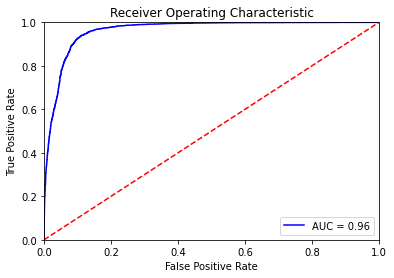

In [58]:
# Compute predicted probabilities on the test set
probs = xlm_roberta_predict(xlm_roberta_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

**Train our Model on the entire Training Data**

---



In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
xlm_roberta_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(xlm_roberta_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.607797   |     -      |     -     |   9.41   
   1    |   40    |   0.503282   |     -      |     -     |   8.94   
   1    |   60    |   0.576910   |     -      |     -     |   8.99   
   1    |   80    |   0.543787   |     -      |     -     |   9.03   
   1    |   100   |   0.496124   |     -      |     -     |   9.00   
   1    |   120   |   0.486400   |     -      |     -     |   8.97   
   1    |   140   |   0.478478   |     -      |     -     |   8.92   
   1    |   160   |   0.506885   |     -      |     -     |   8.91   
   1    |   180   |   0.527853   |     -      |     -     |   8.92   
   1    |   200   |   0.505840   |     -      |     -     |   8.94   
   1    |   220   |   0.525264   |     -      |     -     |   8.92   
   1    |   240   |   0.457774   |     -      |     -     |   8.95   


**Prediction on Test Set**

---



English Tweet

In [59]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs_en, test_masks_en = preprocessing_for_xlm_roberta(X_test_en)
test_labels_en = torch.tensor(y_test_en)

# Create the DataLoader for our test set
test_dataset_en = TensorDataset(test_inputs_en, test_masks_en, test_labels_en)
test_sampler_en = SequentialSampler(test_dataset_en)
test_dataloader_en = DataLoader(test_dataset_en, sampler=test_sampler_en, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Number of tweets predicted non-negative:  4944
AUC: 0.9634
Accuracy: 91.10%
F1 score: 91.00%
Precision: 87.54%
Recall: 94.75%


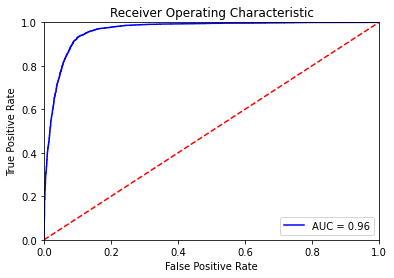

In [60]:
# Compute predicted probabilities on the test set
probs = xlm_roberta_predict(xlm_roberta_classifier, test_dataloader_en)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())
evaluate_roc(probs, y_test_en)

Spanish Tweet

In [61]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs_sp, test_masks_sp = preprocessing_for_xlm_roberta(X_test_sp)
test_labels_sp = torch.tensor(y_test_sp)

# Create the DataLoader for our test set
test_dataset_sp = TensorDataset(test_inputs_sp, test_masks_sp, test_labels_sp)
test_sampler_sp = SequentialSampler(test_dataset_sp)
test_dataloader_sp = DataLoader(test_dataset_sp, sampler=test_sampler_sp, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Number of tweets predicted non-negative:  100
AUC: 0.8803
Accuracy: 84.54%
F1 score: 66.67%
Precision: 64.00%
Recall: 69.57%


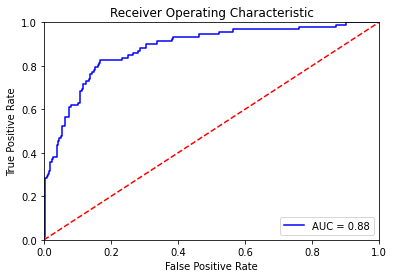

In [62]:
# Compute predicted probabilities on the test set
probs = xlm_roberta_predict(xlm_roberta_classifier, test_dataloader_sp)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())
evaluate_roc(probs, y_test_sp)